# Collaboration and Competition

---

This notebook runs John's solution for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.  It uses the Unity ML-Agents environment to train two cooperative agents to play a tennis-like game.

**Need more description here - refer to readme?**






...


This code depends upon a custom Unity environment provided by the Udacity staff that embodies the variation on tennis.  It will open a separate Unity window for visualizing the environment as the agents train or play.


## Define how we will use this notebook - JOHN FIX THIS!!!!

In the next cell, set the appropriate values of a couple control variables:
- **EXPLORE** determines whether the notebook does exploratory training or inference demonstration.
    - **True** runs a hyperparameter exploration loop to generate many training runs with a random search algorithm.  To use this well, you should study that cell and specify the ranges of hyperparameters to be explored.
    - **False** runs a few inference episodes of a pretrained model and opens a visualization window to watch it play.
- **config_name:** the name of a model configuration & run to be loaded from a checkpoint to begin the exercise.  
    - If EXPLORE = True, this is optional, and tells the training loop to start from this pre-trained model and continue refining it; if the value is _None_ then the training starts from a randomly initialized model.
    - If EXPLORE = False, then this must reflect the name of a legitimate config/run (e.g. "M37.01").
- **checkpoint_episode:** if a checkpoint is being used to start the exercise, then this number reflects what episode that checkpoint was captured from.  The checkpoint_name and checkpoint_episode together are required to completely identify the checkpoint file.


In [1]:
EXPLORE            = True
config_name        = "M37" # Must be None if not using!
run_number         = 29
checkpoint_episode = 2000

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from train import train
from maddpg import Maddpg

%matplotlib inline

initial_episode = checkpoint_episode
checkpoint_path = "checkpoint/{}/".format(config_name)
tag = "{}.{:02d}".format(config_name, run_number)

if EXPLORE:
    turn_off_graphics = True
    initial_episode = 0
    if config_name != None:
        initial_episode = checkpoint_episode
else:
    turn_off_graphics = False

# create a new Unity environment
# it needs to be done once, outside any loop, as closing an environment then restarting causes
# a Unity exception about the handle no longer being active.
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64", seed=0, 
                       no_graphics=turn_off_graphics)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]                       
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Train the agents

The next cells will invoke the training program to create the agents.  All of the real code is in Python flat files in this project directory.

In [3]:
import numpy as np

class RandomSampler():
    
    def __init__(self, vars):
        """Accepts definition of the set of variables to be sampled.
            
            Params:
                vars (list of lists): each item is a list containing:
                                        item 0 - either 'discrete', 'continuous-int' or 'continuous-float'
                                        items 1-N depend on the value of item 0:
                                        if discrete, then these are the set of values to be chosen from
                                        if continuous then these are the min & max bounds of the range
        """
        
        self.vars = vars
        
        self.rng = np.random.default_rng()
    
    
    def sample(self):
        """Draws a random sample of all variables at its disposal.
        
            Returns a list of values in the order of definition.
        """

        rtn = []
        for v in self.vars:
            if v[0] == "discrete":
                choice = self.rng.integers(low=1, high=len(v), size=1)[0]
                rtn.append(v[choice])
                
            elif v[0] == "continuous-int":
                choice = self.rng.integers(low=v[1], high=v[2], size=1)[0]
                rtn.append(choice)
                
            elif v[0] == "continuous-float":
                choice = self.rng.random() * (v[2]-v[1]) + v[1]
                rtn.append(choice)
            
            else:
                print("///// RandomSampler error:  unknown type ", v[0])
            
        return rtn
                
vars = [["discrete", 88, 66, 11, 22, 33, 44, 99, 101, 77],
        ["discrete", 500], #1-item list
        ["continuous-int", 43, 44], #1-item range
        ["continuous-int", 0, 10],
        ["continuous-float", 0.0, 1.0],
        ["continuous-float", -3.3, 0.0],
        ["continuous-float", -1.0, 6.4],
       ]
rs = RandomSampler(vars)

for i in range(3):
    out = rs.sample()
    print("\n", i, "\n", out)



 0 
 [88, 500, 43, 0, 0.9444794569352934, -0.9855378057271817, 6.189161046158313]

 1 
 [88, 500, 43, 1, 0.18121069034258763, -0.0866252850264706, 4.416573454671746]

 2 
 [101, 500, 43, 9, 0.9882088195428095, -0.6664543812619246, 3.549072318566684]


Ready to train M39 over 40 training sets for 15001 episodes each, with fixed params:
    Max episodes   =  15001
    Weight decay   =  0.0
    Gamma          =  0.99
    LR anneal freq =  2000
    LR anneal mult =  0.8
    Buf prime size =  5000

///// Beginning training set  M39.00  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999925
      Noise scale      = 0.030
      LR actor         = 0.0001958
      LR critic        = 0.0001087
      Learning every      75  time steps
      Learn iterations =  1
      Tau              = 0.00271
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer................................................

2000	Average score:   0.000,        mem:   5003/     0 ( 0.0%), avg 1260.2 eps/min;  0.2 hr rem   
2748	Running avg/max: 0.000/0.000,  mem:   6072/     5 ( 0.1%), 

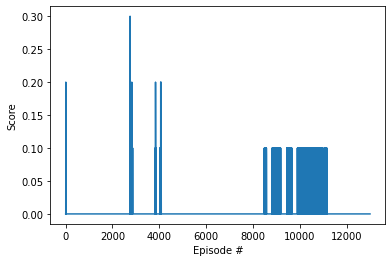

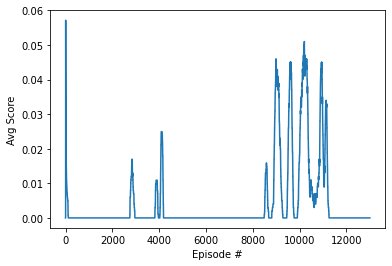


///// Beginning training set  M39.01  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999990
      Noise scale      = 0.048
      LR actor         = 0.0001616
      LR critic        = 0.0003361
      Learning every      76  time steps
      Learn iterations =  2
      Tau              = 0.00234
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer................................................

2000	Average score:   0.000,        mem:   5002/     1 ( 0.0%), avg 2456.3 eps/min;  0.1 hr rem   
4000	Average score:   0.000,        mem:   7935/     5 ( 0.1%), avg 1248.7 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10826/     5 ( 0.0%), avg 1241.2 eps/min;  0.1 hr rem   
7559	Running avg/max: 0.000/0.000,  mem:  13090/     5 ( 0.0%), avg 1238.9 eps/min   
* noise mult = 0.2
8000	Av

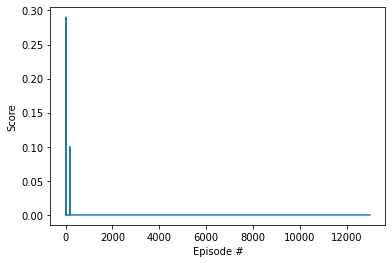

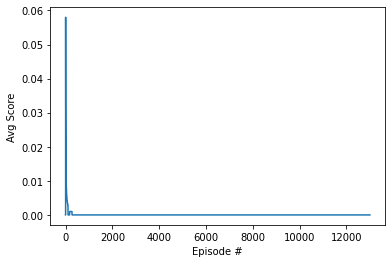


///// Beginning training set  M39.02  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999925
      Noise scale      = 0.041
      LR actor         = 0.0002582
      LR critic        = 0.0000536
      Learning every      94  time steps
      Learn iterations =  2
      Tau              = 0.00177
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5002/     0 ( 0.0%), avg 2245.5 eps/min;  0.1 hr rem   
2755	Running avg/max: 0.000/0.000,  mem:   6097/     0 ( 0.0%), avg 1178.0 eps/min   
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7909/     0 ( 0.0%), avg 1185.3 eps/min;  0.2 hr rem   
5576	Running avg/max: 0.000/0.000,  mem:  10175/     0 ( 0.0%), avg 1191.0 eps/min   
* noise mult = 0.00

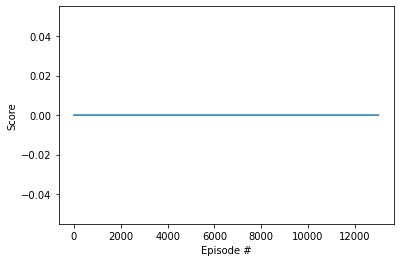

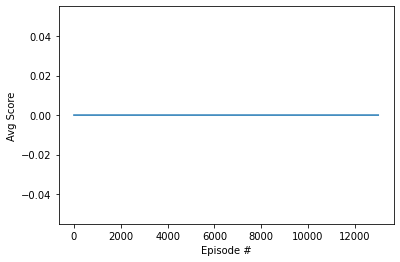


///// Beginning training set  M39.03  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999929
      Noise scale      = 0.047
      LR actor         = 0.0003588
      LR critic        = 0.0000755
      Learning every      67  time steps
      Learn iterations =  2
      Tau              = 0.00145
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5002/     0 ( 0.0%), avg 1039.0 eps/min;  0.2 hr rem   
2800	Running avg/max: 0.000/0.000,  mem:   6155/     0 ( 0.0%), avg 1103.7 eps/min   
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7911/     1 ( 0.0%), avg 1093.0 eps/min;  0.2 hr rem   
5785	Running avg/max: 0.000/0.000,  mem:  10476/     1 ( 0.0%), avg 1089.2 eps/min   
* noise mult = 0.00

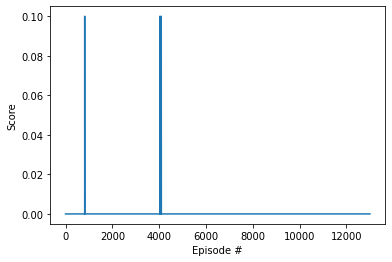

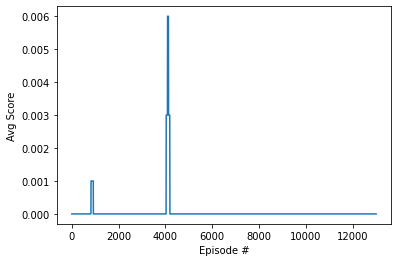


///// Beginning training set  M39.04  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999980
      Noise scale      = 0.046
      LR actor         = 0.0000454
      LR critic        = 0.0001510
      Learning every      81  time steps
      Learn iterations =  1
      Tau              = 0.00207
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer..................................................

2000	Average score:   0.000,        mem:   5001/     1 ( 0.0%), avg 2039.7 eps/min;  0.1 hr rem   
4000	Average score:   0.039,        mem:   8201/    63 ( 0.8%), avg 938.2 eps/min;  0.2 hr rem   
4663	Running avg/max: 0.000/0.000,  mem:   9288/   114 ( 1.2%), avg 944.7 eps/min   
* noise mult = 0.2
6000	Average score:   0.000,        mem:  11172/   114 ( 1.0%), avg 967.5 eps/min;  0.2 hr rem   
8000	Ave

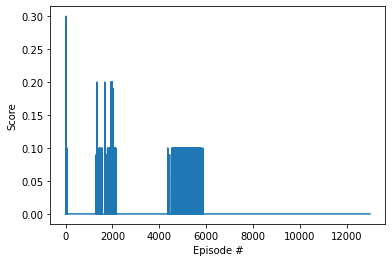

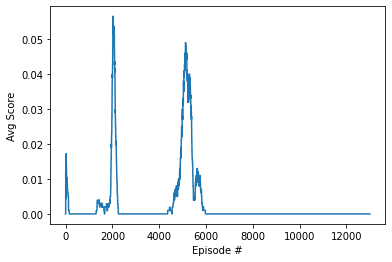


///// Beginning training set  M39.05  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999991
      Noise scale      = 0.042
      LR actor         = 0.0002568
      LR critic        = 0.0002267
      Learning every      100  time steps
      Learn iterations =  2
      Tau              = 0.00253
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5001/     0 ( 0.0%), avg 2078.5 eps/min;  0.1 hr rem   
4000	Average score:   0.014,        mem:   7990/    19 ( 0.2%), avg 1003.6 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10904/    26 ( 0.2%), avg 1016.9 eps/min;  0.2 hr rem   
8000	Average score:   0.000,        mem:  13805/    26 ( 0.2%), avg 1021.7 eps/min;  0.1 hr rem   
8516	Runnin

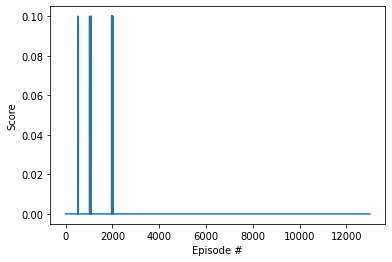

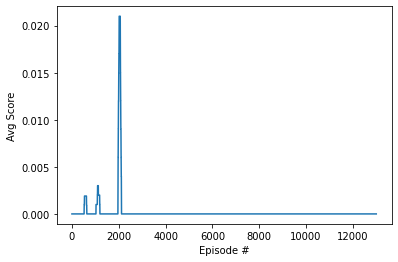


///// Beginning training set  M39.06  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999944
      Noise scale      = 0.040
      LR actor         = 0.0002781
      LR critic        = 0.0000809
      Learning every      71  time steps
      Learn iterations =  1
      Tau              = 0.00143
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer..................................................

2000	Average score:   0.000,        mem:   5002/     0 ( 0.0%), avg 956.9 eps/min;  0.3 hr rem   
3004	Running avg/max: 0.000/0.000,  mem:   6454/     2 ( 0.0%), avg 730.8 eps/min   
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7888/     2 ( 0.0%), avg 760.3 eps/min;  0.3 hr rem   
6000	Average score:   0.000,        mem:  10734/     2 ( 0.0%), avg 761.5 eps/min;  0.2 hr rem   
6765	Runn

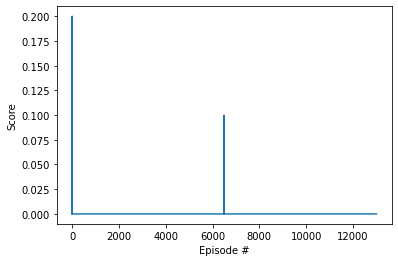

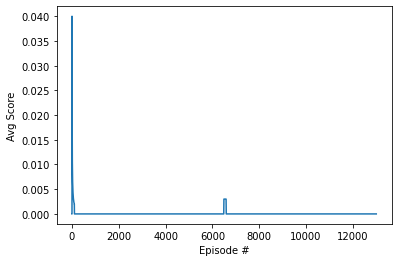


///// Beginning training set  M39.07  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999993
      Noise scale      = 0.047
      LR actor         = 0.0000714
      LR critic        = 0.0003324
      Learning every      64  time steps
      Learn iterations =  1
      Tau              = 0.00211
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer................................................

2000	Average score:   0.000,        mem:   5001/     0 ( 0.0%), avg 1720.7 eps/min;  0.1 hr rem   
4000	Average score:   0.000,        mem:   7974/    19 ( 0.2%), avg 1038.5 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10860/    19 ( 0.2%), avg 1044.1 eps/min;  0.2 hr rem   
8000	Average score:   0.000,        mem:  13779/    19 ( 0.1%), avg 1051.3 eps/min;  0.1 hr rem   
9745	Running 

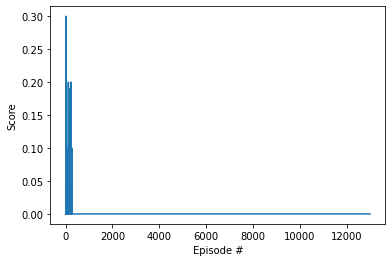

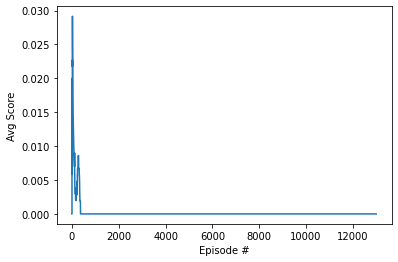


///// Beginning training set  M39.08  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999961
      Noise scale      = 0.046
      LR actor         = 0.0001676
      LR critic        = 0.0001969
      Learning every      71  time steps
      Learn iterations =  2
      Tau              = 0.00170
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer................................................

2000	Average score:   0.000,        mem:   5001/     1 ( 0.0%), avg 2043.9 eps/min;  0.1 hr rem   
3435	Running avg/max: 0.000/0.000,  mem:   7067/     2 ( 0.0%), avg 984.2 eps/min    
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7894/     2 ( 0.0%), avg 998.6 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10778/     2 ( 0.0%), avg 1011.1 eps/min;  0.2 hr rem   
8000	Ave

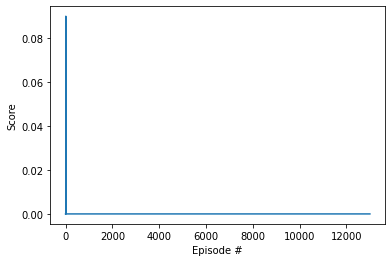

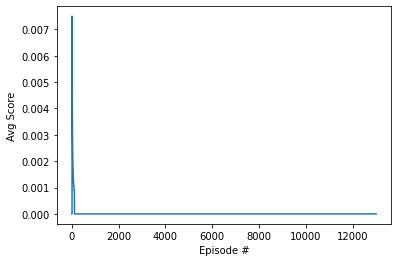


///// Beginning training set  M39.09  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999987
      Noise scale      = 0.047
      LR actor         = 0.0003283
      LR critic        = 0.0003207
      Learning every      73  time steps
      Learn iterations =  1
      Tau              = 0.00177
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5001/     0 ( 0.0%), avg 2954.6 eps/min;  0.1 hr rem   
4000	Average score:   0.000,        mem:   7908/     1 ( 0.0%), avg 1079.8 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10762/     1 ( 0.0%), avg 1091.0 eps/min;  0.2 hr rem   
6257	Running avg/max: 0.000/0.000,  mem:  11128/     1 ( 0.0%), avg 1090.8 eps/min   
* noise mult = 0.2
8000	A

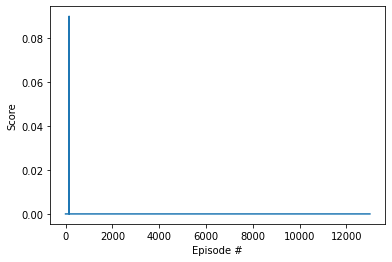

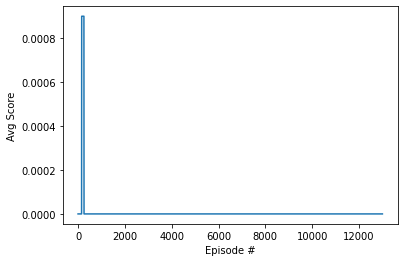


///// Beginning training set  M39.10  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999949
      Noise scale      = 0.035
      LR actor         = 0.0001337
      LR critic        = 0.0003174
      Learning every      77  time steps
      Learn iterations =  2
      Tau              = 0.00147
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer................................................

2000	Average score:   0.100,        mem:   5004/     1 ( 0.0%), avg 1195.4 eps/min;  0.2 hr rem   
3117	Running avg/max: 0.000/0.000,  mem:   6616/     1 ( 0.0%), avg 933.5 eps/min    
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7896/     1 ( 0.0%), avg 963.2 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10793/     1 ( 0.0%), avg 985.1 eps/min;  0.2 hr rem   
7287	Runn

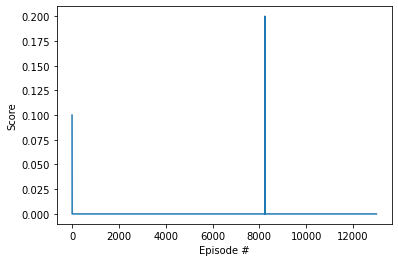

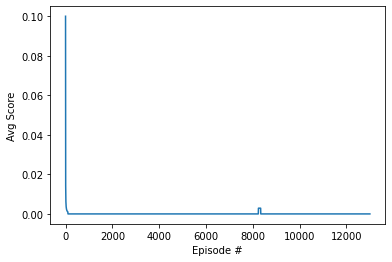


///// Beginning training set  M39.11  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999989
      Noise scale      = 0.052
      LR actor         = 0.0001134
      LR critic        = 0.0001216
      Learning every      97  time steps
      Learn iterations =  2
      Tau              = 0.00248
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5001/     0 ( 0.0%), avg 4954.2 eps/min;  0.1 hr rem   
4000	Average score:   0.000,        mem:   8010/    35 ( 0.4%), avg 922.9 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10886/    35 ( 0.3%), avg 932.8 eps/min;  0.2 hr rem   
6943	Running avg/max: 0.000/0.000,  mem:  12214/    35 ( 0.3%), avg 938.9 eps/min   
* noise mult = 0.2
8000	Aver

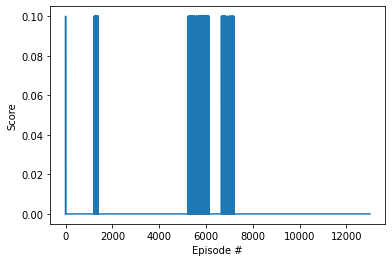

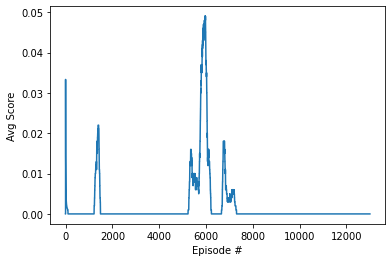


///// Beginning training set  M39.12  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999983
      Noise scale      = 0.050
      LR actor         = 0.0000219
      LR critic        = 0.0002813
      Learning every      66  time steps
      Learn iterations =  2
      Tau              = 0.00162
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5003/     0 ( 0.0%), avg 785.4 eps/min;  0.3 hr rem   
4000	Average score:   0.000,        mem:   7933/    12 ( 0.2%), avg 999.7 eps/min;  0.2 hr rem   
5306	Running avg/max: 0.000/0.000,  mem:   9819/    12 ( 0.1%), avg 1007.7 eps/min   
* noise mult = 0.2
6000	Average score:   0.000,        mem:  10840/    12 ( 0.1%), avg 1011.0 eps/min;  0.2 hr rem   
8000	Ave

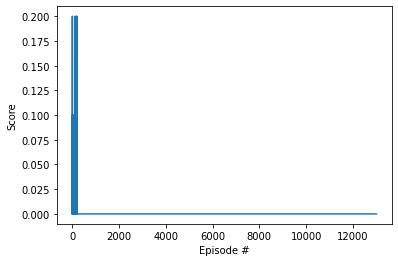

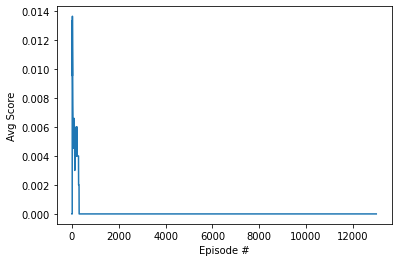


///// Beginning training set  M39.13  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999931
      Noise scale      = 0.044
      LR actor         = 0.0000685
      LR critic        = 0.0000563
      Learning every      62  time steps
      Learn iterations =  2
      Tau              = 0.00158
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.100,        mem:   5003/     1 ( 0.0%), avg 1251.1 eps/min;  0.2 hr rem   
2815	Running avg/max: 0.000/0.000,  mem:   6187/     1 ( 0.0%), avg 991.5 eps/min    
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7914/     1 ( 0.0%), avg 990.2 eps/min;  0.2 hr rem   
5869	Running avg/max: 0.000/0.000,  mem:  10608/     1 ( 0.0%), avg 993.5 eps/min   
* noise mult = 0.0005

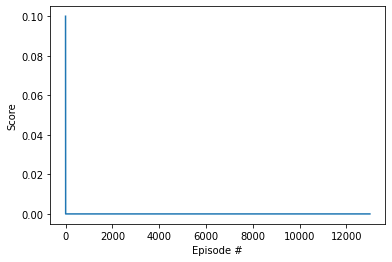

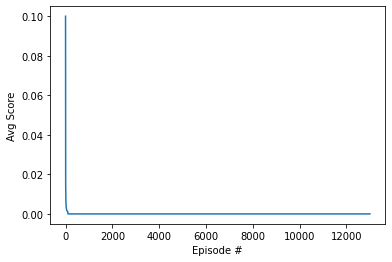


///// Beginning training set  M39.14  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999990
      Noise scale      = 0.039
      LR actor         = 0.0003439
      LR critic        = 0.0001496
      Learning every      60  time steps
      Learn iterations =  2
      Tau              = 0.00233
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer..................................................

2000	Average score:   0.090,        mem:   5004/     1 ( 0.0%), avg 1064.3 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        mem:   7896/     2 ( 0.0%), avg 989.1 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10753/     2 ( 0.0%), avg 987.2 eps/min;  0.2 hr rem   
7468	Running avg/max: 0.000/0.000,  mem:  12914/     2 ( 0.0%), avg 959.5 eps/min   
* noise mult = 0.2
8000	Ave

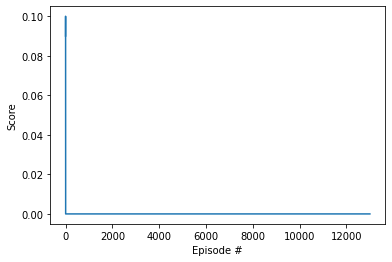

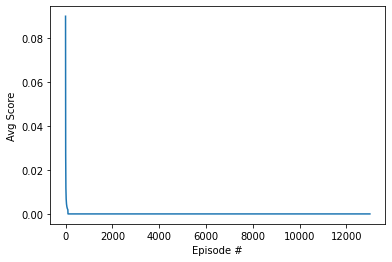


///// Beginning training set  M39.15  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999946
      Noise scale      = 0.042
      LR actor         = 0.0002563
      LR critic        = 0.0003258
      Learning every      69  time steps
      Learn iterations =  2
      Tau              = 0.00142
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5002/     1 ( 0.0%), avg 2151.2 eps/min;  0.1 hr rem   
3042	Running avg/max: 0.000/0.000,  mem:   6509/    10 ( 0.2%), avg 838.1 eps/min    
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7928/    10 ( 0.1%), avg 848.6 eps/min;  0.3 hr rem   
6000	Average score:   0.000,        mem:  10795/    10 ( 0.1%), avg 851.1 eps/min;  0.2 hr rem   
6969	Run

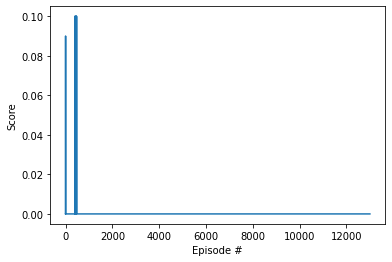

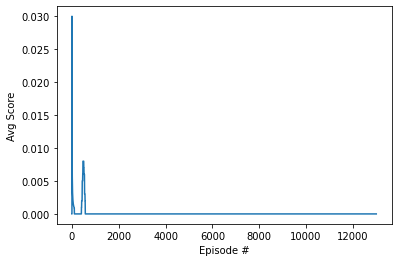


///// Beginning training set  M39.16  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999964
      Noise scale      = 0.044
      LR actor         = 0.0002629
      LR critic        = 0.0003284
      Learning every      60  time steps
      Learn iterations =  1
      Tau              = 0.00239
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5002/     0 ( 0.0%), avg 2416.4 eps/min;  0.1 hr rem   
3591	Running avg/max: 0.000/0.000,  mem:   7305/     2 ( 0.0%), avg 1036.1 eps/min   
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7895/     2 ( 0.0%), avg 1036.8 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10787/     2 ( 0.0%), avg 1017.9 eps/min;  0.2 hr rem   
8000	A

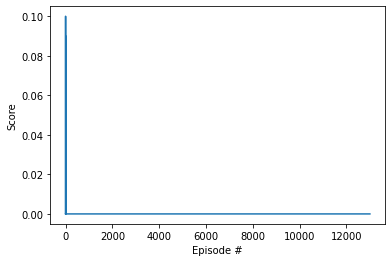

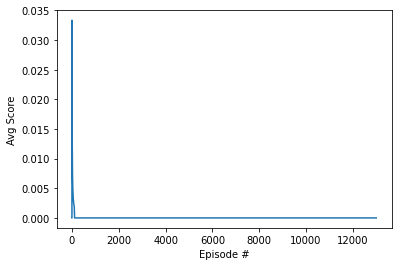


///// Beginning training set  M39.17  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999986
      Noise scale      = 0.033
      LR actor         = 0.0002602
      LR critic        = 0.0003034
      Learning every      82  time steps
      Learn iterations =  1
      Tau              = 0.00186
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5002/     0 ( 0.0%), avg 1547.9 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        mem:   7901/     0 ( 0.0%), avg 1240.3 eps/min;  0.2 hr rem   
6000	Average score:   0.002,        mem:  10857/    11 ( 0.1%), avg 1234.3 eps/min;  0.1 hr rem   
6130	Running avg/max: 0.000/0.000,  mem:  11047/    11 ( 0.1%), avg 1235.0 eps/min   
* noise mult = 0.2
8000	A

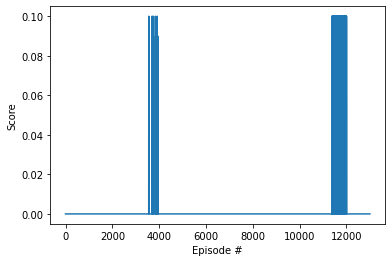

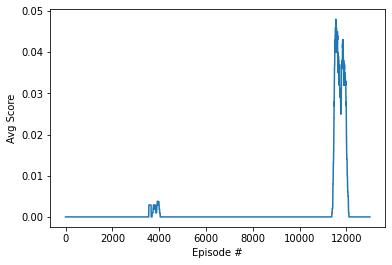


///// Beginning training set  M39.18  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999952
      Noise scale      = 0.050
      LR actor         = 0.0000245
      LR critic        = 0.0001648
      Learning every      91  time steps
      Learn iterations =  1
      Tau              = 0.00233
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer................................................

2000	Average score:   0.000,        mem:   5001/     0 ( 0.0%), avg 2886.9 eps/min;  0.1 hr rem   
3158	Running avg/max: 0.000/0.000,  mem:   6706/    16 ( 0.2%), avg 1120.5 eps/min   
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7976/    29 ( 0.4%), avg 1121.2 eps/min;  0.2 hr rem   
6000	Average score:   0.002,        mem:  11188/    73 ( 0.7%), avg 1092.5 eps/min;  0.2 hr rem   
7106	Ru

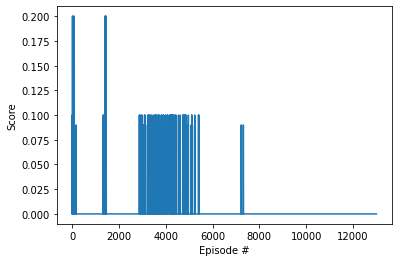

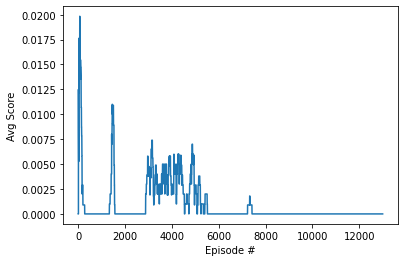


///// Beginning training set  M39.19  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999990
      Noise scale      = 0.040
      LR actor         = 0.0000586
      LR critic        = 0.0000740
      Learning every      76  time steps
      Learn iterations =  2
      Tau              = 0.00179
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer................................................

2000	Average score:   0.000,        mem:   5003/     0 ( 0.0%), avg 1473.9 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        mem:   7877/     1 ( 0.0%), avg 844.3 eps/min;  0.3 hr rem   
6000	Average score:   0.000,        mem:  10778/     1 ( 0.0%), avg 835.6 eps/min;  0.2 hr rem   
7776	Running avg/max: 0.000/0.000,  mem:  13339/     1 ( 0.0%), avg 844.5 eps/min   
* noise mult = 0.2
8000	Avera

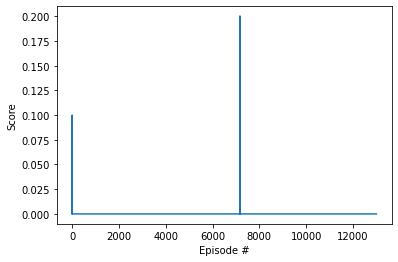

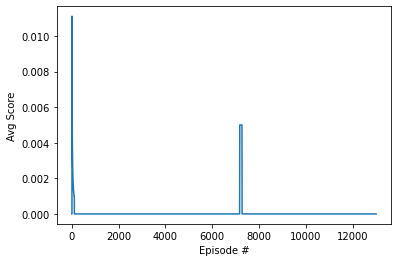


///// Beginning training set  M39.20  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999998
      Noise scale      = 0.053
      LR actor         = 0.0002163
      LR critic        = 0.0000867
      Learning every      77  time steps
      Learn iterations =  1
      Tau              = 0.00269
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer..................................................

2000	Average score:   0.000,        mem:   5001/     1 ( 0.0%), avg 1964.5 eps/min;  0.1 hr rem   
4000	Average score:   0.000,        mem:   7910/     5 ( 0.1%), avg 1118.9 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10767/     5 ( 0.0%), avg 1115.3 eps/min;  0.2 hr rem   
8000	Average score:   0.000,        mem:  13688/     5 ( 0.0%), avg 1113.9 eps/min;  0.1 hr rem   
10000	Avera

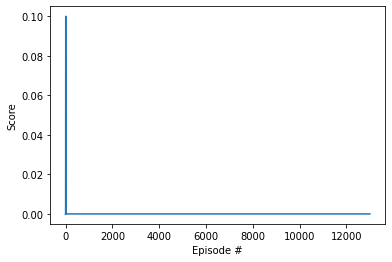

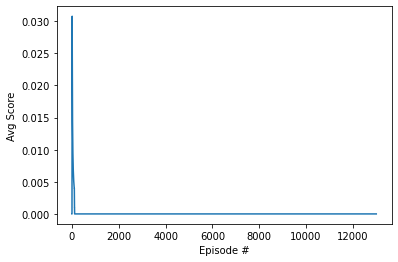


///// Beginning training set  M39.21  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999945
      Noise scale      = 0.044
      LR actor         = 0.0002277
      LR critic        = 0.0000899
      Learning every      77  time steps
      Learn iterations =  1
      Tau              = 0.00219
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer................................................

2000	Average score:   0.100,        mem:   5003/     1 ( 0.0%), avg 1168.8 eps/min;  0.2 hr rem   
3028	Running avg/max: 0.000/0.000,  mem:   6475/     2 ( 0.0%), avg 1111.4 eps/min   
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7859/     2 ( 0.0%), avg 1102.4 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10794/     4 ( 0.0%), avg 1085.6 eps/min;  0.2 hr rem   
6825	Ru

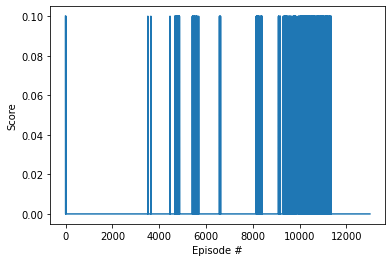

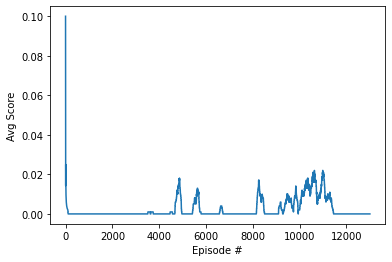


///// Beginning training set  M39.22  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999993
      Noise scale      = 0.031
      LR actor         = 0.0003754
      LR critic        = 0.0003578
      Learning every      77  time steps
      Learn iterations =  2
      Tau              = 0.00261
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer..................................................

2000	Average score:   0.000,        mem:   5002/     1 ( 0.0%), avg 1776.7 eps/min;  0.1 hr rem   
4000	Average score:   0.000,        mem:   8098/    59 ( 0.7%), avg 845.4 eps/min;  0.3 hr rem   
6000	Average score:   0.000,        mem:  10971/    61 ( 0.6%), avg 863.7 eps/min;  0.2 hr rem   
8000	Average score:   0.000,        mem:  13884/    61 ( 0.4%), avg 872.4 eps/min;  0.2 hr rem   
10000	Average 

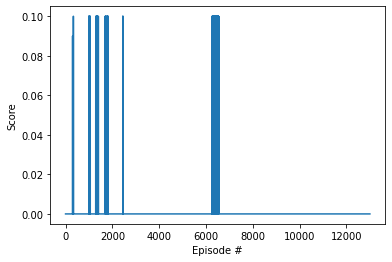

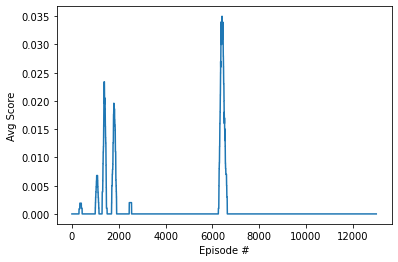


///// Beginning training set  M39.23  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999960
      Noise scale      = 0.049
      LR actor         = 0.0002561
      LR critic        = 0.0001204
      Learning every      89  time steps
      Learn iterations =  1
      Tau              = 0.00186
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.090,        mem:   5003/     1 ( 0.0%), avg 1661.6 eps/min;  0.2 hr rem   
3409	Running avg/max: 0.000/0.000,  mem:   7050/     1 ( 0.0%), avg 1133.2 eps/min   
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7913/     1 ( 0.0%), avg 1142.6 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10773/     1 ( 0.0%), avg 1144.7 eps/min;  0.2 hr rem   
8000	A

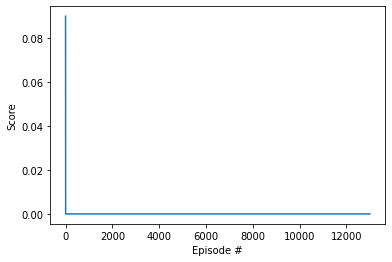

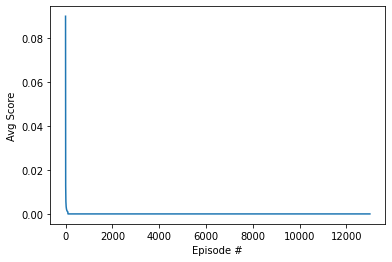


///// Beginning training set  M39.24  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999951
      Noise scale      = 0.040
      LR actor         = 0.0001159
      LR critic        = 0.0003847
      Learning every      72  time steps
      Learn iterations =  2
      Tau              = 0.00187
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.100,        mem:   5006/     1 ( 0.0%), avg 1204.8 eps/min;  0.2 hr rem   
3147	Running avg/max: 0.000/0.000,  mem:   6657/     1 ( 0.0%), avg 1033.1 eps/min   
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7913/     1 ( 0.0%), avg 1040.6 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10778/     1 ( 0.0%), avg 1042.0 eps/min;  0.2 hr rem   
7435	R

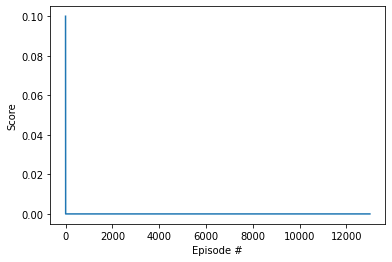

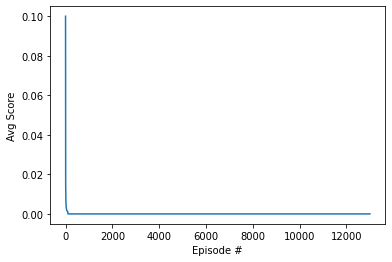


///// Beginning training set  M39.25  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999970
      Noise scale      = 0.036
      LR actor         = 0.0003740
      LR critic        = 0.0001409
      Learning every      81  time steps
      Learn iterations =  1
      Tau              = 0.00214
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5001/     0 ( 0.0%), avg 1745.7 eps/min;  0.1 hr rem   
3883	Running avg/max: 0.000/0.000,  mem:   7758/    12 ( 0.2%), avg 1245.5 eps/min   
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7924/    12 ( 0.2%), avg 1243.6 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10822/    14 ( 0.1%), avg 1244.0 eps/min;  0.1 hr rem   
8000	A

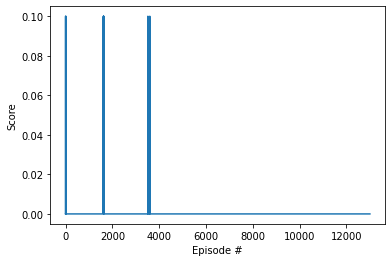

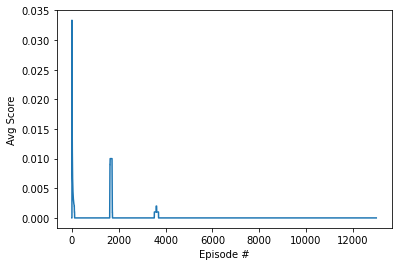


///// Beginning training set  M39.26  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999967
      Noise scale      = 0.034
      LR actor         = 0.0001798
      LR critic        = 0.0000646
      Learning every      99  time steps
      Learn iterations =  2
      Tau              = 0.00229
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5001/     1 ( 0.0%), avg 2035.8 eps/min;  0.1 hr rem   
3724	Running avg/max: 0.000/0.000,  mem:   7504/     1 ( 0.0%), avg 1112.5 eps/min   
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7899/     1 ( 0.0%), avg 1113.9 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10753/     1 ( 0.0%), avg 1114.2 eps/min;  0.2 hr rem   
8000	A

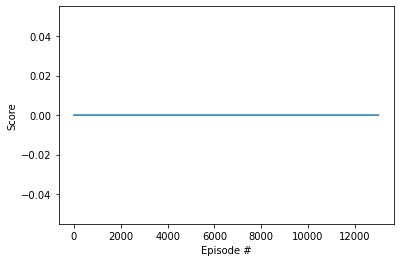

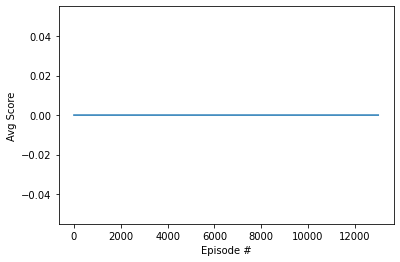


///// Beginning training set  M39.27  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999981
      Noise scale      = 0.053
      LR actor         = 0.0003403
      LR critic        = 0.0002188
      Learning every      85  time steps
      Learn iterations =  1
      Tau              = 0.00154
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer................................................

2000	Average score:   0.000,        mem:   5001/     0 ( 0.0%), avg 4002.1 eps/min;  0.1 hr rem   
4000	Average score:   0.006,        mem:   7990/    16 ( 0.2%), avg 1109.8 eps/min;  0.2 hr rem   
4831	Running avg/max: 0.000/0.000,  mem:   9419/    97 ( 1.0%), avg 1073.2 eps/min   
* noise mult = 0.2
6000	Average score:   0.000,        mem:  11112/    98 ( 0.9%), avg 1089.1 eps/min;  0.2 hr rem   
8000	Av

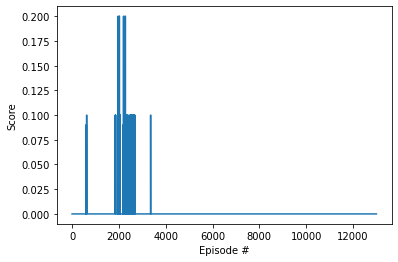

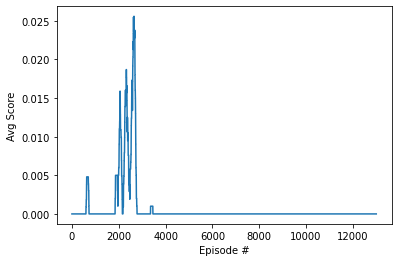


///// Beginning training set  M39.28  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999998
      Noise scale      = 0.035
      LR actor         = 0.0003478
      LR critic        = 0.0002953
      Learning every      70  time steps
      Learn iterations =  1
      Tau              = 0.00194
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5002/     1 ( 0.0%), avg 1486.2 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        mem:   7916/     3 ( 0.0%), avg 1073.2 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10802/     3 ( 0.0%), avg 1076.6 eps/min;  0.2 hr rem   
8000	Average score:   0.000,        mem:  13736/     3 ( 0.0%), avg 1074.6 eps/min;  0.1 hr rem   
10000	Averag

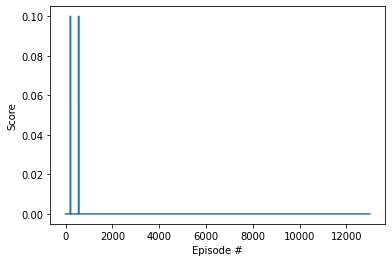

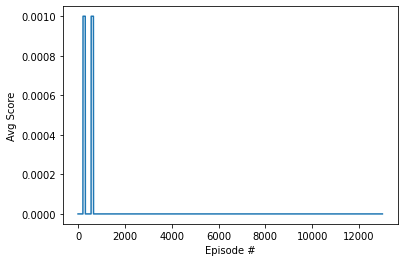


///// Beginning training set  M39.29  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999960
      Noise scale      = 0.050
      LR actor         = 0.0001715
      LR critic        = 0.0003772
      Learning every      71  time steps
      Learn iterations =  1
      Tau              = 0.00193
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer................................................

2000	Average score:   0.000,        mem:   5004/     0 ( 0.0%), avg 1816.3 eps/min;  0.1 hr rem   
3320	Running avg/max: 0.000/0.000,  mem:   7026/     6 ( 0.1%), avg 1157.6 eps/min   
* noise mult = 0.2
4000	Average score:   0.000,        mem:   8002/     6 ( 0.1%), avg 1176.7 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10906/     6 ( 0.1%), avg 1202.5 eps/min;  0.2 hr rem   
8000	Av

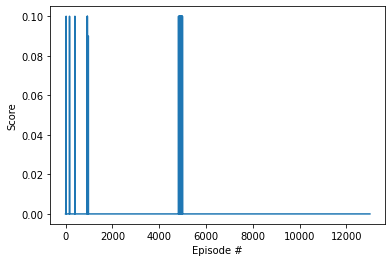

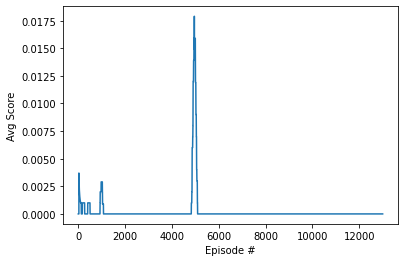


///// Beginning training set  M39.30  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999936
      Noise scale      = 0.045
      LR actor         = 0.0000200
      LR critic        = 0.0001693
      Learning every      85  time steps
      Learn iterations =  2
      Tau              = 0.00155
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5001/     0 ( 0.0%), avg 4935.1 eps/min;  0.1 hr rem   
2846	Running avg/max: 0.000/0.000,  mem:   6262/    14 ( 0.2%), avg 975.4 eps/min    
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7961/    14 ( 0.2%), avg 1041.8 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10813/    15 ( 0.1%), avg 1054.8 eps/min;  0.2 hr rem   
6159	R

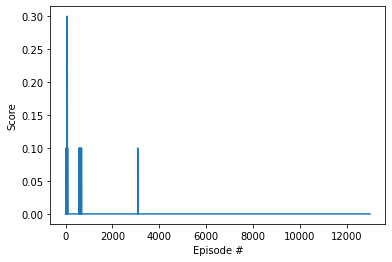

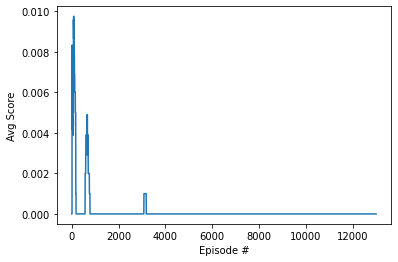


///// Beginning training set  M39.31  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999946
      Noise scale      = 0.044
      LR actor         = 0.0001128
      LR critic        = 0.0001093
      Learning every      84  time steps
      Learn iterations =  1
      Tau              = 0.00251
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5006/     0 ( 0.0%), avg 1112.9 eps/min;  0.2 hr rem   
3040	Running avg/max: 0.000/0.000,  mem:   6514/     2 ( 0.0%), avg 1233.6 eps/min   
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7916/     2 ( 0.0%), avg 1241.5 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10807/     2 ( 0.0%), avg 1244.8 eps/min;  0.1 hr rem   
6942	R

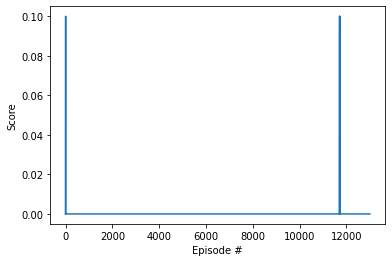

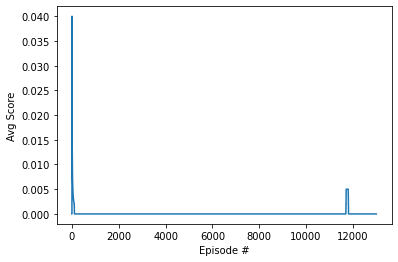


///// Beginning training set  M39.32  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999947
      Noise scale      = 0.040
      LR actor         = 0.0001122
      LR critic        = 0.0000771
      Learning every      65  time steps
      Learn iterations =  2
      Tau              = 0.00256
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.090,        mem:   5003/     1 ( 0.0%), avg 1930.6 eps/min;  0.1 hr rem   
3059	Running avg/max: 0.000/0.000,  mem:   6525/     1 ( 0.0%), avg 1013.2 eps/min   
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7892/     1 ( 0.0%), avg 1014.1 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10740/     1 ( 0.0%), avg 995.7 eps/min;  0.2 hr rem   
7015	Ru

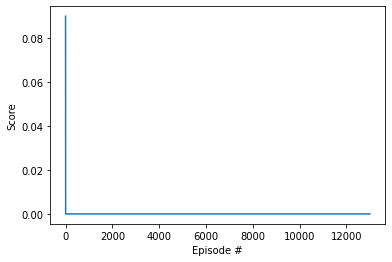

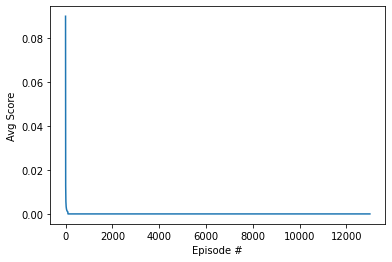


///// Beginning training set  M39.33  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999955
      Noise scale      = 0.043
      LR actor         = 0.0001734
      LR critic        = 0.0003685
      Learning every      82  time steps
      Learn iterations =  2
      Tau              = 0.00270
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5001/     0 ( 0.0%), avg 6400.5 eps/min;  0.0 hr rem   
3165	Running avg/max: 0.000/0.000,  mem:   6800/     6 ( 0.1%), avg 858.1 eps/min    
* noise mult = 0.2
4000	Average score:   0.000,        mem:   8013/     6 ( 0.1%), avg 882.5 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10889/    13 ( 0.1%), avg 890.9 eps/min;  0.2 hr rem   
7775	Run

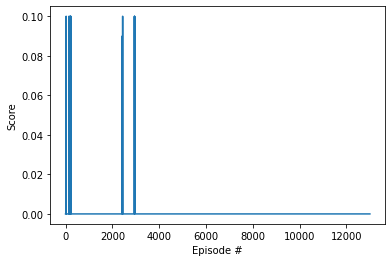

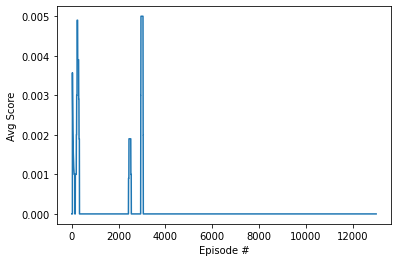


///// Beginning training set  M39.34  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999966
      Noise scale      = 0.036
      LR actor         = 0.0002070
      LR critic        = 0.0002077
      Learning every      100  time steps
      Learn iterations =  2
      Tau              = 0.00254
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5002/     0 ( 0.0%), avg 1967.1 eps/min;  0.1 hr rem   
3647	Running avg/max: 0.000/0.000,  mem:   7382/     2 ( 0.0%), avg 1084.0 eps/min   
* noise mult = 0.2
4000	Average score:   0.001,        mem:   7914/     9 ( 0.1%), avg 1086.4 eps/min;  0.2 hr rem   
6000	Average score:   0.007,        mem:  11110/   107 ( 1.0%), avg 1074.6 eps/min;  0.2 hr rem   
8000	

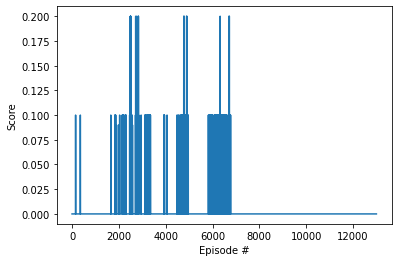

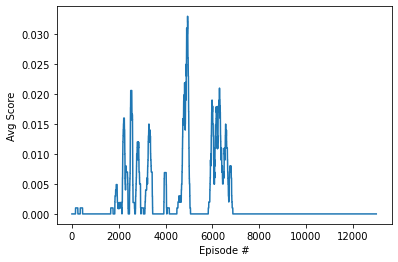


///// Beginning training set  M39.35  with:
      Batch size       = 128
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999945
      Noise scale      = 0.051
      LR actor         = 0.0001987
      LR critic        = 0.0001024
      Learning every      73  time steps
      Learn iterations =  2
      Tau              = 0.00196
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5003/     0 ( 0.0%), avg 2805.2 eps/min;  0.1 hr rem   
3025	Running avg/max: 0.000/0.000,  mem:   6465/     0 ( 0.0%), avg 1104.2 eps/min   
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7884/     0 ( 0.0%), avg 1088.5 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  11047/    74 ( 0.7%), avg 1066.8 eps/min;  0.2 hr rem   
6694	R

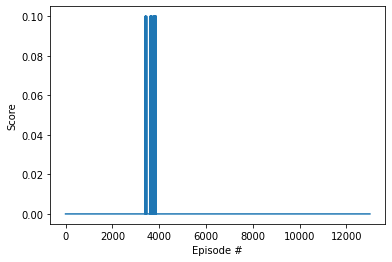

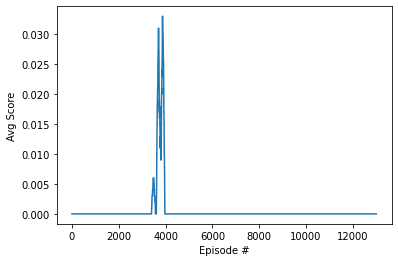


///// Beginning training set  M39.36  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999962
      Noise scale      = 0.038
      LR actor         = 0.0001709
      LR critic        = 0.0000930
      Learning every      85  time steps
      Learn iterations =  1
      Tau              = 0.00207
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5004/     1 ( 0.0%), avg 1832.5 eps/min;  0.1 hr rem   
3474	Running avg/max: 0.000/0.000,  mem:   7136/     7 ( 0.1%), avg 1330.6 eps/min   
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7914/     7 ( 0.1%), avg 1335.3 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10793/     7 ( 0.1%), avg 1334.8 eps/min;  0.1 hr rem   
8000	A

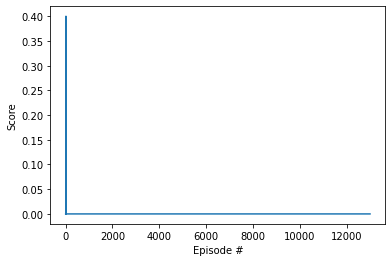

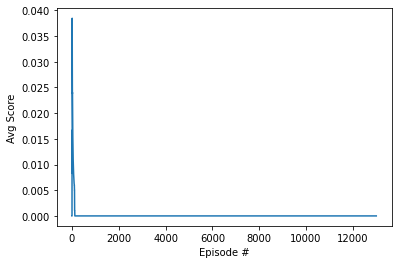


///// Beginning training set  M39.37  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999988
      Noise scale      = 0.037
      LR actor         = 0.0002371
      LR critic        = 0.0003925
      Learning every      76  time steps
      Learn iterations =  1
      Tau              = 0.00176
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer.................................................

2000	Average score:   0.000,        mem:   5002/     0 ( 0.0%), avg 1841.2 eps/min;  0.1 hr rem   
4000	Average score:   0.000,        mem:   7919/     2 ( 0.0%), avg 1240.2 eps/min;  0.2 hr rem   
6000	Average score:   0.000,        mem:  10807/     2 ( 0.0%), avg 1172.2 eps/min;  0.2 hr rem   
6551	Running avg/max: 0.000/0.000,  mem:  11555/     2 ( 0.0%), avg 1161.8 eps/min   
* noise mult = 0.2
8000	A

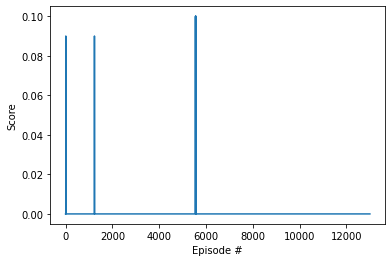

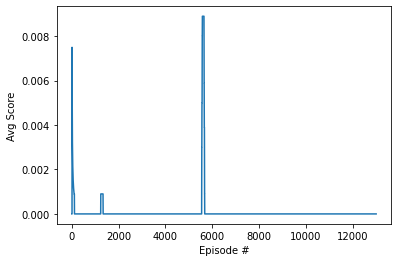


///// Beginning training set  M39.38  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999978
      Noise scale      = 0.036
      LR actor         = 0.0002989
      LR critic        = 0.0001234
      Learning every      72  time steps
      Learn iterations =  1
      Tau              = 0.00190
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer................................................

2000	Average score:   0.000,        mem:   5005/     0 ( 0.0%), avg 895.4 eps/min;  0.3 hr rem   
4000	Average score:   0.000,        mem:   7872/     4 ( 0.1%), avg 1236.0 eps/min;  0.2 hr rem   
4513	Running avg/max: 0.000/0.000,  mem:   8625/     4 ( 0.0%), avg 1236.2 eps/min   
* noise mult = 0.2
6000	Average score:   0.000,        mem:  10776/     4 ( 0.0%), avg 1243.4 eps/min;  0.1 hr rem   
8000	Ave

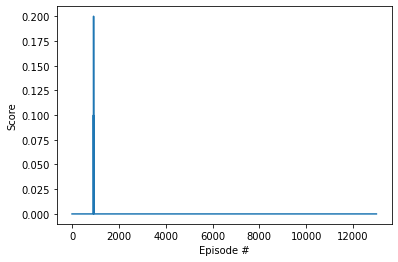

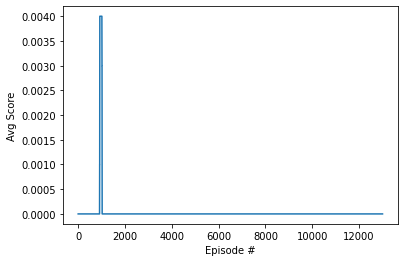


///// Beginning training set  M39.39  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1000
      Noise decay      = 0.999932
      Noise scale      = 0.044
      LR actor         = 0.0003486
      LR critic        = 0.0001057
      Learning every      90  time steps
      Learn iterations =  1
      Tau              = 0.00268
      Seed             =  44939
///// Beginning training from checkpoint for M37.29, episode 2000
Checkpoint loaded for M37.29, episode 2000
Priming the replay buffer................................................

2000	Average score:   0.100,        mem:   5004/     1 ( 0.0%), avg 1537.5 eps/min;  0.2 hr rem   
2832	Running avg/max: 0.000/0.000,  mem:   6202/     4 ( 0.1%), avg 1299.9 eps/min   
* noise mult = 0.2
4000	Average score:   0.000,        mem:   7876/     4 ( 0.1%), avg 1270.5 eps/min;  0.2 hr rem   
5953	Running avg/max: 0.000/0.000,  mem:  10719/     4 ( 0.0%), avg 1315.7 eps/min   
* noise mult = 0.000

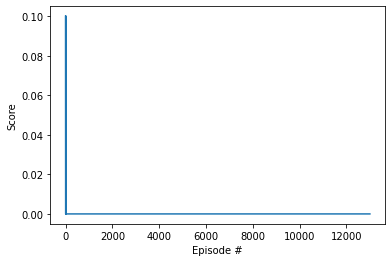

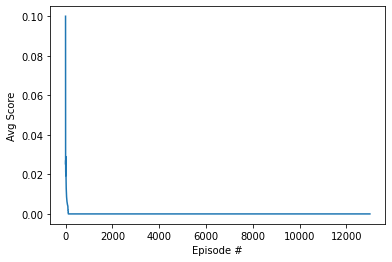



DONE!


In [4]:
# This cell will explore several combinations of hyperparams by training all of them
# Use a random search for the hyperparams

TIME_STEPS         = 600
SAVE_ANALYSIS      = False
MODEL_DISPLAY_STEP = 0 #200k is approx 10k episodes at bad_step_prob = 0.01

if EXPLORE:
    
    # fixed for the session:
    RUN_PREFIX        = "M39"
    EPISODES          = 15001
    NUM_RUNS          = 40
    BAD_STEP_PROB     = 0.1
    BUFFER_PRIME_SIZE = 5000
    WEIGHT_DECAY      = 0.0 #was 1.0e-5
    GAMMA             = 0.99
    LR_ANNEAL_FREQ    = 2000 #episodes
    LR_ANNEAL_MULT    = 0.8
    SEED              = 44939 #(0, 111, 468, 5555, 23100, 44939)
    
    # session variables:
    vars = [
            ["continuous-float", 0.15,     0.23],     #BAD_STEP_PROB
            ["continuous-float", 0.999924, 0.999999], #NOISE_DECAY
            ["continuous-float", 0.030,    0.054],    #NOISE_SCALE
            ["continuous-float", 0.000020, 0.000400], #LR_ACTOR  (was 0.000010, 0.000080)
            ["continuous-float", 0.000010, 0.000400], #LR_CRITIC (was 0.000001, 0.000020)
            ["continuous-int",   60,       101],      #LEARN_EVERY
            ["continuous-int",   1,        3],        #LEARN_ITER
            ["continuous-float", 0.00140,  0.00280],  #TAU
            ["discrete",         128, 256]            #BATCH
           ]
    rs = RandomSampler(vars)
    
    print("Ready to train {} over {} training sets for {} episodes each, with fixed params:"
          .format(RUN_PREFIX, NUM_RUNS, EPISODES))
    print("    Max episodes   = ", EPISODES)
    print("    Weight decay   = ", WEIGHT_DECAY)
    print("    Gamma          = ", GAMMA)
    print("    LR anneal freq = ", LR_ANNEAL_FREQ)
    print("    LR anneal mult = ", LR_ANNEAL_MULT)
    print("    Buf prime size = ", BUFFER_PRIME_SIZE)
            
    for set_id in range(NUM_RUNS):
        
        # sample the variables
        v = rs.sample()
        #BAD_STEP_PROB = v[0]
        NOISE_DECAY   = v[1]
        NOISE_SCALE   = v[2]
        LR_ACTOR      = v[3]
        LR_CRITIC     = v[4]
        LEARN_EVERY   = v[5]
        LEARN_ITER    = v[6]
        TAU           = v[7]
        BATCH         = v[8]

        # set the replay buffer size to that it fills after ~5000 bad episodes
        # (at ~14 experiences/episode), based on the bad step retention rate
        #buffer_size = int(60000 - 50000*(1.0 - BAD_STEP_PROB))
        buffer_size = 100000

        RUN_NAME = "{}.{:02d}".format(RUN_PREFIX, set_id)
        print("\n///// Beginning training set ", RUN_NAME, " with:")
        print("      Batch size       = {:d}".format(BATCH))
        print("      Buffer size      = {:d}".format(buffer_size))
        print("      Bad step prob    = {:.4f}".format(BAD_STEP_PROB))
        print("      Noise decay      = {:.6f}".format(NOISE_DECAY))
        print("      Noise scale      = {:.3f}".format(NOISE_SCALE))
        print("      LR actor         = {:.7f}".format(LR_ACTOR))
        print("      LR critic        = {:.7f}".format(LR_CRITIC))
        print("      Learning every     ", LEARN_EVERY, " time steps")
        print("      Learn iterations = ", LEARN_ITER)
        print("      Tau              = {:.5f}".format(TAU))
        print("      Seed             = ", SEED)

        ##### instantiate the agents and perform the training

        maddpg = Maddpg(state_size, action_size, 2, bad_step_prob=BAD_STEP_PROB,
                        random_seed=SEED, batch_size=BATCH, buffer_size=buffer_size,
                        noise_decay=NOISE_DECAY, buffer_prime_size=BUFFER_PRIME_SIZE,
                        learn_every=LEARN_EVERY, 
                        learn_iter=LEARN_ITER, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC,
                        lr_anneal_freq=LR_ANNEAL_FREQ, lr_anneal_mult=LR_ANNEAL_MULT,
                        weight_decay=WEIGHT_DECAY, gamma=GAMMA, noise_scale=NOISE_SCALE,
                        tau=TAU, model_display_step=MODEL_DISPLAY_STEP)
        
        if config_name != None:
            print("///// Beginning training from checkpoint for {}, episode {}" \
                  .format(tag, initial_episode))
            maddpg.restore_checkpoint(checkpoint_path, tag, initial_episode)

        scores, avgs = train(maddpg, env, run_name=RUN_NAME, starting_episode=initial_episode,
                             max_episodes=EPISODES, winning_score=0.5, max_time_steps=TIME_STEPS,
                             checkpoint_interval=2000)

        ##### plot the training reward history

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(avgs)), avgs)
        plt.ylabel('Avg Score')
        plt.xlabel('Episode #')
        plt.show()

        ##### store the action/noise data, if being used

        if SAVE_ANALYSIS:
            maddpg.save_anal_data(RUN_PREFIX)

                            
    print("\n\nDONE!")

# HEY JOHN - TODO!

- update main.py to match the above code {ALL CELLS}
- Test running from cmd line (may need a script?)
- Clean up the bottom part of this notebook

### Run two trained agents against each other (inference mode)

Note:  before running this cell, the Unity environment object will need to be defined (at top of notebook) with `no_graphics=False` so that the graphical game display will appear.

In [5]:
if not EXPLORE:
    
    # load the pre-trained model
    model = Maddpg(state_size, action_size, 2)
    model.restore_checkpoint(checkpoint_path, tag, initial_episode)

    for i in range(10):                                        # play game for several episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        num_steps = 0
        while True:
            actions = model.act(states, add_noise=False)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            num_steps += 1
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Episode {}: {:5.3f}, took {} steps'.format(i, np.max(scores), num_steps))


When finished, you can close the environment.

In [6]:
env.close()